# Structural Modeling

The following notebook is comprised of 9 primary steps:

1. Initialize required packages, directories and parameters 
2. Load and inspect the surface data
3. Decluster and normal score transform
4. Variogram calculation and modeling
5. Simulation and back-transformation
6. Simulation checking 
7. Base surface calculation
8. 3-D grid and keyout calculation
9. Save project setting and clean the output files

## 1. Initialize required packages and parameters

In [1]:
import pygeostat as gs
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

Loading default Pygeostat Parameters from C:\Users\MostafaHadavand\.Pygeostat\Parameters.json


### Load project settings and modify where required
Load the Matplotlib and Pygeostat project defaults.

In [2]:
gs.Parameters.load('Parameters.json')
gs.PlotStyle.load('Parameters.json')

Assign the number of realization and griddef to variables for convenience.

In [3]:
nreal = gs.Parameters['data.nreal']
print('nreal = {}'.format(nreal))
griddef = gs.Parameters['data.griddef']
print(griddef)

nreal = 100
120 5.0 10.0 
110 1205.0 10.0 
1 0.5 1.0


The cmap was set to bwr in the previous section - reset to the 
Matplotlib default

In [4]:
gs.Parameters['plotting.cmap'] = 'viridis'

### Directories and files

In [5]:
# create the output directory
outdir = 'Output/'
gs.mkdir(outdir)

## 2. Load and inspect the surface data

### Load the data and note its attributes

In [6]:
dat = gs.ExampleData('reservoir_surface')
print('columns = {}'.format(dat.columns.values))
print('x column = {}, y column = {}'.format(dat.x, dat.y))

columns = ['HoleID' 'X' 'Y' 'Top Elevation' 'Thickness' 'Base Elevation']
x column = X, y column = Y


### Summary statistics
The DataFile describe excludes special attributes.

In [7]:
dat.describe()

,Top Elevation,Thickness,Base Elevation
count,230.000000,230.000000,230.000000
mean,379.173739,50.096391,329.077348
std,2.607090,4.376842,4.571519
min,372.070000,37.730000,315.850000
25%,377.222500,47.502500,327.137500
50%,378.950000,49.390000,329.140000
75%,380.782500,51.900000,332.225000
max,386.330000,62.870000,340.870000


### Location map

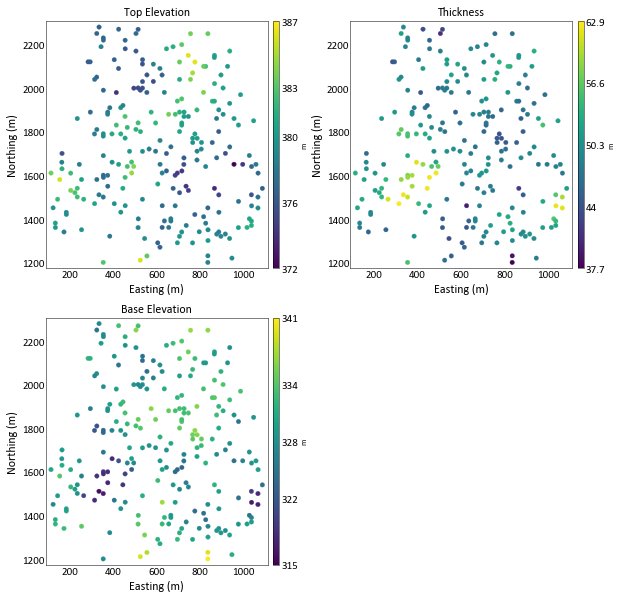

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for var, ax in zip(dat.variables, axes):
    gs.location_plot(dat, var=var, cbar_label='m', title=var, ax=ax)
# Remove the unneeded fourth axis
axes[-1].remove()

## 3. Decluster and Normal Score Transform

Declustering defines the spatially representative distribution of the Top Elevation and Thickness. These distributions are then used for the normal score transformation, generating conditioning data that is used for calculating normal score variograms and conditioning sequential Gaussian simulation.

Note that variograms are often calculated on data that are normal score transformed without declustering weights. Given the controversy of the subject, the more convenient method is selected for this course (since declustering with weights is absolutely required for conditioning).

### Decluster the data
All variables are homotopically sampled, so only one variable need be considered for declustering.


In [9]:
declus = gs.Program('declus')

In [10]:
# Cell size based on the data spacing study in the intro notebook
cellsize = 90
parstr = """   Parameters for DECLUS
                  *********************

START OF PARAMETERS:
{datafl}                 -file with data
{xyzcol}   {varcol}      -  columns for X, Y, Z, and variable
-1.0e21     1.0e21       -  trimming limits
junk.out                 -file for summary output
{outfl}                  -file for output with data & weights
1.0   1.0                   -Y and Z cell anisotropy (Ysize=size*Yanis)
0                           -0=look for minimum declustered mean (1=max)
1  {cellsize}  {cellsize}   -number of cell sizes, min size, max size
5                           -number of origin offsets
"""
pars = dict(datafl=dat.flname, xyzcol=dat.gscol(dat.xyz),
            varcol=dat.gscol('Top Elevation'),
            outfl=os.path.join(outdir, 'declus.out'), cellsize=cellsize)
declus.run(parstr=parstr.format(**pars))
gs.rmfile('junk.out')

Calling:  ['declus', 'temp']

DECLUS Version: 3.000

 data file = c:\users\mostafahadavand\anaconda3\envs\
 columns =            2           3           0           4
 tmin,tmax =    -1.000000E+21    1.000000E+21
 summary file = junk.out                                
 output file = Output/declus.out                       
 anisotropy =         1.000000        1.000000
 minmax flag =            0
 ncell min max =            1       90.000000       90.000000
 offsets =            5


There are      230 data with:
  mean value            =    379.17374
  minimum and maximum   =    372.07001   386.32999
  size of data vol in X =    970.03998
  size of data vol in Y =   1080.00000
  size of data vol in Z =      0.00000

  declustered mean      =    379.24036
  min and max weight    =      0.42091     2.19493
  equal weighting       =      1.00000


DECLUS Version: 3.000 Finished

Stop - Program terminated.


### Load and inspect the declustering results

In the context of the upcoming modeling steps, Base Elevation is not considered a variable. Use of the notvariables kwarg on initialization excludes it from the variables attribute.

In [11]:
dat = gs.DataFile('Output/declus.out', notvariables='Base Elevation')
print('declustering weight = ', dat.weights)
print('variables = ', dat.variables)

declustering weight =  Declustering Weight
variables =  ['Top Elevation', 'Thickness']


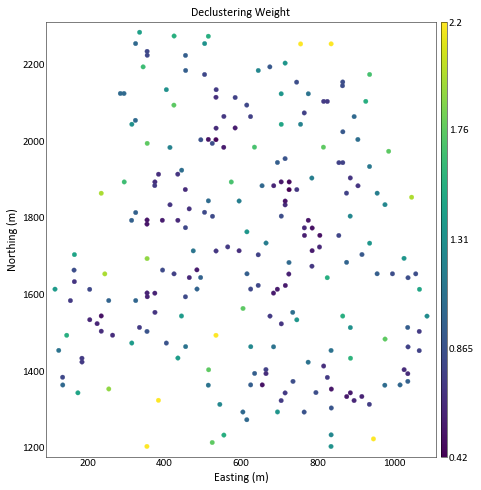

In [12]:
gs.location_plot(dat, var=dat.weights)

### Normal score transform

In [13]:
unscore = gs.Program('unscore')

In [14]:
parstr = """   Parameters for NSCORE
                  *********************

START OF PARAMETERS:
{datafl}                  -file with data
{nvar} {varcols}          -  number of variables and columns
{wtcol}                   -  column for weight, 0 if none
0                         -  column for category, 0 if none
0                         -  number of records if known, 0 if unknown
-1.0e21   1.0e21          -  trimming limits
0                         -transform using a reference distribution, 1=yes
../histsmth/histsmth.out  -file with reference distribution.
1   2   0                 -columns for variable, weight, and category
1000                       -maximum number of quantiles, 0 for all
{outfl}                   -file for output
{trnfl}                   -file for output transformation table
"""
pars = dict(datafl=dat.flname, nvar=dat.nvar,
            varcols=dat.gscol(dat.variables),
            wtcol=dat.gscol(dat.weights),
            outfl = os.path.join(outdir, 'nscore.out'), trnfl = os.path.join(outdir,'nscore.trn'))
unscore.run(parstr=parstr.format(**pars))

Calling:  ['unscore', 'temp']
 UNSCORE Version: 1.1.1
 data file = Output/declus.out
  columns =            4           5           7           0
  number of records =            0
  trimming limits =  -1.000000000000000E+021  1.000000000000000E+021
  consider a different reference dist =            0
  file with reference distribution = ../histsmth/histsmth.out                
  columns =            1           2           0
  maximum number of quantiles =         1000
  file for output = Output/nscore.out
  file for transformation table = Output/nscore.trn
 Determining size of Output/declus.out
 Reading Output/declus.out
 Building transform table   1 category   1
 Building transform table   2 category   1
 Computing normal scores    1 category   1
 Computing normal scores    2 category   1
 Generating output file
 Total execution time 0.060 seconds.

 UNSCORE Version: 1.1.1 Finished



### Load and inspect the normal score transformation result

Use the notvariables kwarg leads to isolation of the normal score variables as the dat_ns.variables attribute. Since DataFiles with iniitialized wts are passed to histplt, wt may be True.

In [15]:
dat_ns = gs.DataFile(os.path.join(outdir, 'nscore.out'), 
                     notvariables=['Base Elevation']+dat.variables)
print('variables = ', dat_ns.variables)

variables =  ['NS_Top Elevation', 'NS_Thickness']


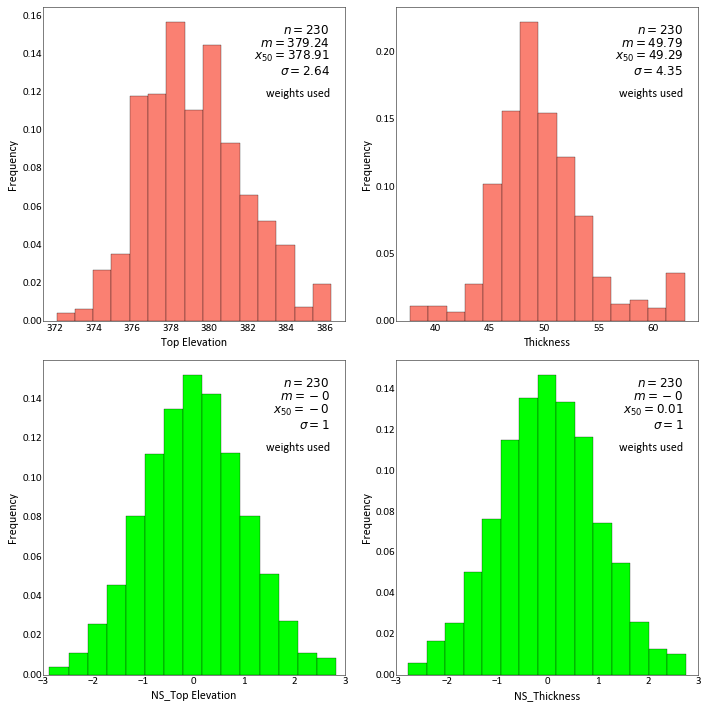

In [16]:
fig, axes = plt.subplots(2 , 2, figsize=(10, 10))
for var, ax in zip(dat.variables, axes[0]):
    gs.histogram_plot(dat, var=var, weights=True, ax=ax, stat_blk='minimal', color='salmon')
for var, ax in zip(dat_ns.variables, axes[1]):
    gs.histogram_plot(dat_ns, var, weights=True, ax=ax, 
               xlim=(-3, 3), stat_blk='minimal', color='lime')  
fig.tight_layout()

## 4. Variogram Calculation and Modeling
Normal score variograms are calculated and modeled, before being input to sequential Gaussian simulation in the next section.


In [17]:
var_calc = gs.Program(program='varcalc')

In [18]:
parstr = """      Parameters for VARCALC
                  **********************
 
START OF PARAMETERS:
{file}                             -file with data
2 3 0                              -   columns for X, Y, Z coordinates
2 8 9                           -   number of variables,column numbers (position used for tail,head variables below)
{t_min}    1.0e21                   -   trimming limits
{n_directions}                                  -number of directions
0.0 90 10000 0.0 22.5 1000 0.0   -Dir 01: azm,azmtol,bandhorz,dip,diptol,bandvert,tilt
 {n_lag}  {lag_length}  {lag_tol}            -        number of lags,lag distance,lag tolerance
{output}                          -file for experimental variogram points output.
0                                 -legacy output (0=no, 1=write out gamv2004 format)
1                                 -run checks for common errors
1                                 -standardize sills? (0=no, 1=yes)
2                                 -number of variogram types
1   1   1   1                     -tail variable, head variable, variogram type (and cutoff/category), sill
2   2   1   1                     -tail variable, head variable, variogram type (and cutoff/category), sill
"""

n_directions = 1
varcalc_outfl = os.path.join(outdir, 'varcalc.out')

var_calc.run(parstr=parstr.format(file=dat_ns.flname,
                                  n_directions = 1,
                                  t_min = gs.Parameters['data.tmin'],
                                  n_lag=10,
                                  lag_length = 30.0,
                                  lag_tol = 20.0,
                                  output=varcalc_outfl),
             liveoutput=True)

Calling:  ['varcalc', 'temp']

varcalc version:  1.002

  data file: Output/nscore.out
  x,y,z columns:            2           3           0
  number of variables:            2
  Variable columns:            8           9
  tmin,tmax:   -998.000000000000       1.000000000000000E+021
  number of directions:            1
  direction parameters:
 azm,azmtol,bandhorz  0.000000000000000E+000   90.0000000000000     
   10000.0000000000     
 dip,diptol,bandvert  0.000000000000000E+000   22.5000000000000     
   1000.00000000000     
 tilt  0.000000000000000E+000
 nlags,lagdist,lagtol          10   30.0000000000000     
   20.0000000000000     
  output file: Output/varcalc.out
  legacy output?            0
  run checks?            1
  attempt to standardize sills?            1
  number of variogram types:            2
 Variogram tail,head,type           1           1           1
  standardizing with sill =   1.00000000000000     
 Variogram tail,head,type           2           2           1


In [19]:
varfl_exp = gs.DataFile(varcalc_outfl)
varfl_exp.head()

,Variogram Index,Lag Distance,Number of Pairs,Variogram Value,Variogram Number,Calculation Azimuth,Calculation Dip,Variogram Type
0,1.0,13.055639,44.0,0.013837,1.0,0.0,0.0,1.0
1,1.0,34.531689,407.0,0.100780,1.0,0.0,0.0,1.0
2,1.0,61.017428,790.0,0.262916,1.0,0.0,0.0,1.0
3,1.0,90.311682,1250.0,0.447996,1.0,0.0,0.0,1.0
4,1.0,120.364562,1541.0,0.610774,1.0,0.0,0.0,1.0


In [20]:
var_model = gs.Program(program='varmodel')

In [21]:
parstr = """      Parameters for VARMODEL
                  ***********************
 
START OF PARAMETERS:
{varmodel_outfl}             -file for modeled variogram points output
1                            -number of directions to model points along
0.0   0.0  150   3          -  azm, dip, npoints, point separation
2    0.01                   -nst, nugget effect
3    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
3    ?    0.0   0.0   0.0    -it,cc,azm,dip,tilt (ang1,ang2,ang3)
        ?     ?     ?    -a_hmax, a_hmin, a_vert (ranges)
1   100000                   -fit model (0=no, 1=yes), maximum iterations
1.0                          -  variogram sill (can be fit, but not recommended in most cases)
1                            -  number of experimental files to use
{varcalc_outfl}              -    experimental output file 1
1 {var_index}                          -      # of variograms (<=0 for all), variogram #s
1   0   10                   -  # pairs weighting, inverse distance weighting, min pairs
0     10.0                   -  fix Hmax/Vert anis. (0=no, 1=yes)
1      1.0                   -  fix Hmin/Hmax anis. (0=no, 1=yes)
{varmodelfit_outfl}          -  file to save fit variogram model
"""



for i, variable in enumerate(dat_ns.variables):
    varmodel_outfl = os.path.join(outdir, 'varmodel_{}.out'.format(variable.replace(' ', '')))
    varmodelfit_outfl = os.path.join(outdir, 'varmodelfit_{}.out'.format(variable.replace(' ', '')))
    var_model.run(parstr=parstr.format(varmodel_outfl= varmodel_outfl,
                                       varmodelfit_outfl = varmodelfit_outfl,
                                       var_index = i+1,
                                       varcalc_outfl = varcalc_outfl), liveoutput=False, quiet=True)


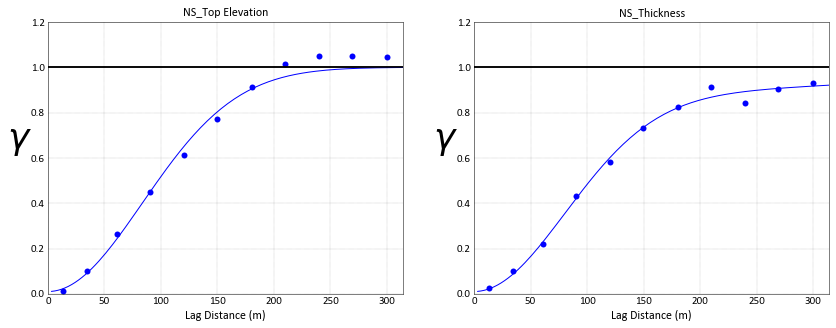

In [22]:
fig, axes = plt.subplots(1 , 2, figsize=(14, 5))

for i, variable in enumerate(dat_ns.variables):
    varmodel_outfl = os.path.join(outdir, 'varmodel_{}.out'.format(variable.replace(' ', '')))
    varmdl = gs.DataFile(varmodel_outfl)
    gs.variogram_plot(varfl_exp, index = i+1, color = 'b', grid=True,
                      label='Experimental Variogram', title=variable, ax = axes[i])
    gs.variogram_plot(varmdl, index = 1, color = 'b', 
                      label='Model Variogram', title=variable, ax = axes[i], experimental=False)
    

## 5. Simulation and Back-transformation
The Top Elevation and Thickness is simulated using sequential Gaussian simulation, before back-transforming to original units.

### Sequential Gaussian Simulation

In [23]:
simdir = os.path.join(outdir,'USGSIM/')
gs.mkdir(simdir)
usgsim = gs.Program('usgsim')

In [24]:
# loading the variogram models
var_models = []
for i, variable in enumerate(dat_ns.variables):
    varmodelfit_outfl = os.path.join(outdir, 'varmodelfit_{}.out'.format(variable.replace(' ', '')))
    with open(varmodelfit_outfl, 'r') as f:
        varmodel_ = f.readlines()
    varstr = ''''''
    for line in varmodel_:
        varstr += line
        
    var_models.append(varstr)

In [25]:
parstr = """               Parameters for USGSIM
                              *********************

START OF MAIN:
1                             -number of realizations to generate, 0=kriging
2                             -number of variables being simulated
0                             -number of rock types to consider
{seed}                        -random number seed
{griddef}
{outfl}                       -file for simulation output
0                             -  output format: (0=reg, 1=coord, 2=binary)
impute.out                    -file for imputed values in case of heterotopic samples
0                             -debugging level: 0,1,2,3
sgsim.dbg                     -file for debugging output 

START OF SRCH:
25                            -number of data to use per variable
300 300   10                  -maximum search radii (hmax,hmin,vert)
0 0 0                         -angles for search ellipsoid
1                             -sort by distance (0) or covariance (1)
0 1 1                         -if sorting by covariance, indicate variogram rock type, head, tail to use

START OF VARG:
2                             -number of variograms
0  1  1                       -rock type, variable 1, variable 2
{varmodel1}
0  2  2                       -rock type, variable 1, variable 2
{varmodel2}

START OF DATA:
{datafl}                      -file with primary data
{xyzcols}    0  0             -  columns for X,Y,Z,wt,rock type
{varcols}                     -  columns for variables
1                             -  clip data to grid, 1=yes
1                             -  assign to the grid, 0=none, 1=nearest, 2=average
-8.0       1.0e21             -  trimming limits
"""
pars = dict(griddef=griddef, varmodel1=var_models[0],
            varmodel2=var_models[1], datafl=dat_ns.flname, 
            xyzcols=dat_ns.gscol(dat_ns.xyz), 
            varcols=dat_ns.gscol(dat_ns.variables))
callpars = []
seeds = gs.rseed_list(nreal, seed=23243)
for i, seed in enumerate(seeds):  
    pars['seed'] = seed
    pars['outfl'] = simdir+'real{}.out'.format(i+1)
    callpars.append(dict(parstr=parstr.format(**pars)))  
gs.runparallel(usgsim, callpars, progressbar=True)

Creating parallel processes


Pool assembled, asynchronously processing
Asynchronous execution finished.



### Inspect a Gaussian realization
This step is not strictly required, but is presented for demonstration.

In [26]:
# Read in the simulation to inspect
sim = gs.DataFile(os.path.join(simdir,'real1.out'))

# Rename the simulation columns
sim.data.columns=dat_ns.variables
sim.variables = dat_ns.variables

# Summary statistics
print('\nProperties of the realization:\n', sim.describe())


Properties of the realization:
        NS_Top Elevation  NS_Thickness
count      13200.000000  13200.000000
mean           0.071186      0.007674
std            0.967378      0.971566
min           -2.974593     -2.961546
25%           -0.569353     -0.647463
50%            0.156086     -0.051394
75%            0.756869      0.612130
max            2.861071      2.774545


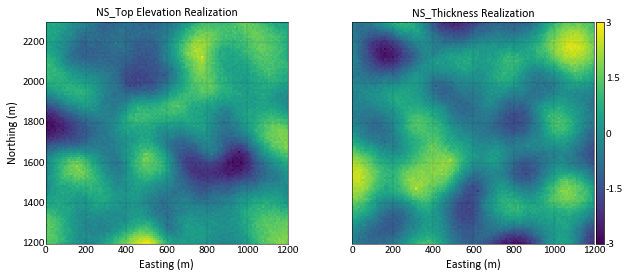

In [27]:
# The gs.subplots is useful when multiple panels are plotted that 
# should use the same colorbar
fig, axes = gs.subplots(1, 2, figsize=(10, 10), cbar_mode='single')
for var, ax in zip(dat_ns.variables, axes):
    gs.slice_plot(sim, var=var, vlim=(-3, 3), title=var+' Realization', ax=ax, grid=True)

### Back-transformation
Note that ubacktr program only requires a prefix of the transformation table, before it infers the file name based on the number of variables and categories.

In [28]:
backdir = os.path.join(outdir,'UBACKTR')
gs.mkdir(backdir)
ubacktr = gs.Program('ubacktr')

In [29]:
parstr = """                  Parameters for UBACKTR
                  **********************
 
START OF PARAMETERS: 
{datafl}                    -file with simulated Gaussian variables (see Note6)
-7.0 1.0e21                 -  trimming limits
2                           -  number of variables
1 2                         -  columns for variables
0                           -number of rocktypes (NRT) (0 if none)
nofile.out                  -  file for simulated RTs (see Note1 and Note6)
5                           -  column for RT 
31 32 34 35 36 37           -  RT category codes (see Note2)
{nx} {ny} 1                 -nx, ny, nz (0=calculated)(see Note3)
1                           -number of realizations
{trnfl}                     -prefix for trans tables (see Note4 and Note7)
{outfl}                     -output file (see Note6)
"""
pars = dict(nx=griddef.nx, ny=griddef.ny, trnfl=os.path.join(outdir,'nscore'))
callpars = []
for i in range(nreal):
    pars['datafl'] = os.path.join(simdir,'real{}.out'.format(i+1))
    pars['outfl'] = os.path.join(backdir,'real{}.out'.format(i+1))
    callpars.append(dict(parstr=parstr.format(**pars)))
gs.runparallel(ubacktr, callpars, progressbar=True)

# Remove the Gaussian realizations since they're no longer needed
gs.rmdir(simdir)

Creating parallel processes


Pool assembled, asynchronously processing
Asynchronous execution finished.



### Realization maps
Generate a figure for each variable, where a single color bar is used for multiple realizations.

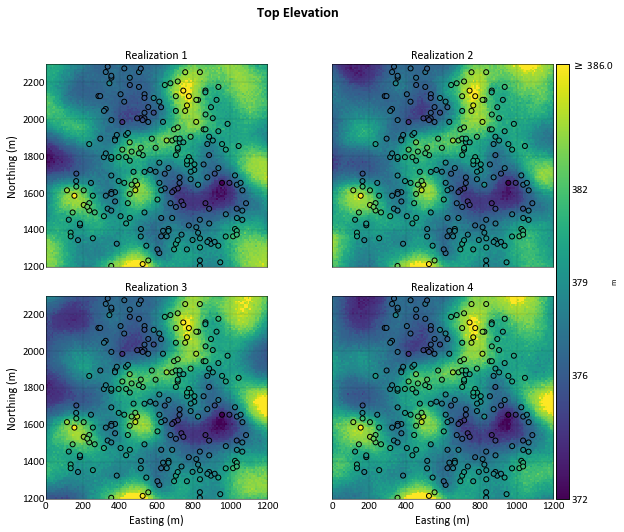

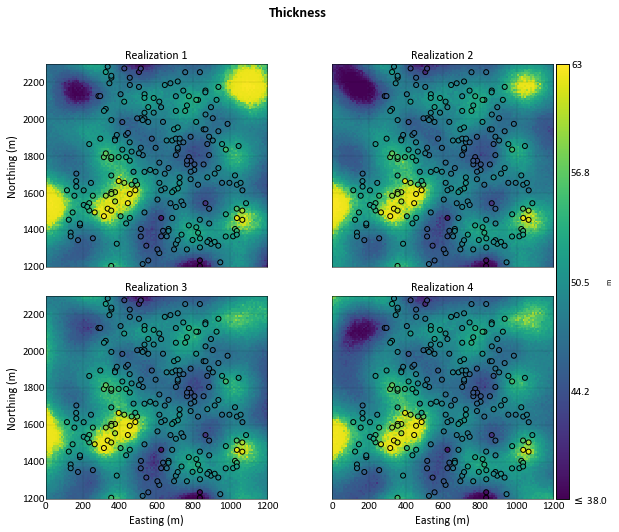

In [30]:
for var in dat.variables:
    fig, axes = gs.subplots(2, 2, figsize=(10, 8), cbar_mode='single')
    # Color limits based on the data
    vlim = (np.round(dat[var].min()), np.round(dat[var].max()))
    for real, ax in enumerate(axes):
        sim = gs.DataFile(os.path.join(backdir,'real{}.out').format(real+1))
        # Renaming columns
        sim.data.columns = dat.variables
        sim.variables = dat.variables
        gs.slice_plot(sim, var=var, title='Realization {}'.format(real+1),
                    pointdata=dat, pointkws={'edgecolors':'k', 's':25, 'lw': 1},
                    vlim=vlim, cbar_label='m', ax=ax, grid=True)

    # Label the figure
    fig.suptitle(var, **{'weight':'bold'})

## 6. Simulation Checking

Check that the realizations reproduce the histogram and variogram of the data.

### Histogram reproduction

#### Option 1:

Using histogram plot iteratively

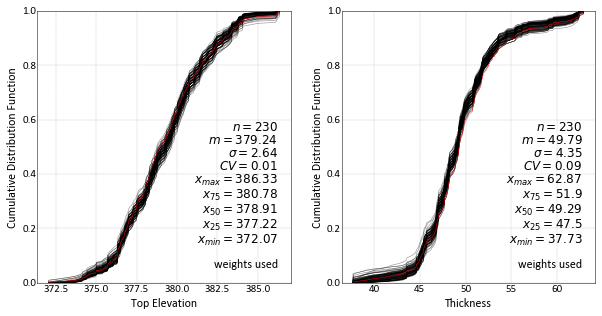

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Realizations
for real in range(nreal):
    sim = gs.DataFile(os.path.join(backdir,'real{}.out').format(real+1))
    # Renaming columns
    sim.data.columns = dat.variables
    sim.variables = dat.variables
    
    for i, (var, ax) in enumerate(zip(dat.variables, axes)):
        gs.histogram_plot(sim, var=var, ax=ax, icdf=True, color='k', grid =True, stat_blk=False, alpha=0.5, lw = 0.5)

# Reference data
for i, (var, ax) in enumerate(zip(dat.variables, axes)):
    gs.histogram_plot(dat, var=var, ax=ax, icdf=True, color='r', grid =True, weights='Declustering Weight', lw = 0.5)

### Option 2

Using histogram plot for simulation results and a '*' wildcard that leads the plotting function to assume 1,...,nreal files are present.

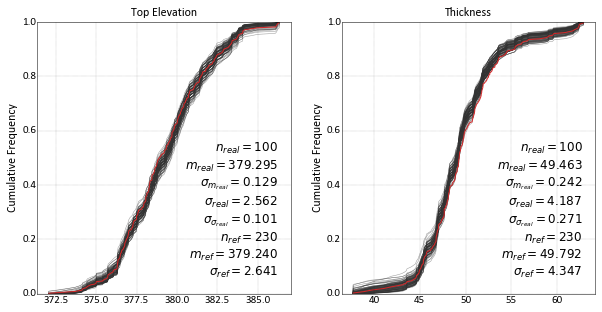

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
for i, (var, ax) in enumerate(zip(dat.variables, axes)):
    gs.histogram_plot_simulation(os.path.join(backdir,'real*.out'), dat, reference_variable=var, 
                                 reference_weight=True, reference_color='C3', simulated_column=i+1, 
                                 title=var, ax=ax, grid=True)

### Variogram reproduction

The variogram of the data in original units must be calculated first, since the normal score variogram was previously calculated.

In [33]:
# # Calculate the experimental data variograms
# vargs = []
# for var, ax in zip(dat.variables, axes):
#     varg = gs.Variogram(dat, var, ndim=2, ndir=1, omnihz=True, 
#                         mute=True)
#     varg.update_calcpars(nlags=10, lagdist=30.0, lagtol=20.0, azm=0, 
#                          azmtol=90, bandhorz=10000, variostd=True)
#     varg.varcalc()    
#     vargs.append(varg)

In [34]:
# gs.log_progress()

In [35]:
# # Calculate the variograms of the realizations
# for i, varg in enumerate(gs.log_progress(vargs)):
#     varg.update_simpars(datafl=backdir+'real*.gsb', nvar=1, 
#                         varcols=i+1)
#     varg.varsim(maxlags=50, vargrng=500)

In [36]:
# # Plot the variograms
# fig, axes = plt.subplots(1, 2, figsize=(10, 4))
# for var, varg, ax in zip(dat.variables, vargs, axes):
#     fig = varg.plot(sim=True, titles=var, colors=['C3'],
#                     figsize=(8, 3), axes=ax)
# fig.tight_layout()

## 7. Construct the Base Surface Realizations
Subtract the thickness from the top elevation, providing the base elevation realizations. Output all values within a single directory.

In [37]:
surfdir=os.path.join(outdir,'Surfaces')
gs.mkdir(surfdir)
for real in range(nreal):
    sim = gs.DataFile(os.path.join(backdir,'real{}.out'.format(real+1)))
    sim.data.columns=['Top Elevation', 'Thickness']
    sim['Base Elevation'] = sim['Top Elevation'] - sim['Thickness']
    sim.write_file(os.path.join(surfdir,'real{}.out'.format(real+1)))

Text(0.5,0.98,'Base Elevation')

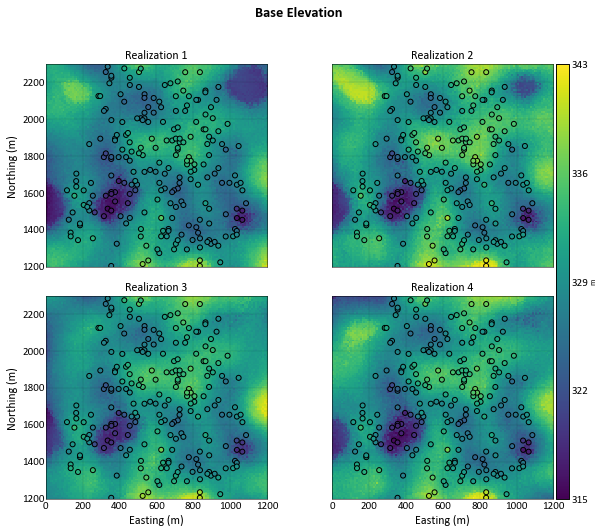

In [38]:
var = 'Base Elevation'
vlim = (np.round(dat[var].min()), np.round(dat[var].max()))
fig, axes = gs.subplots(2, 2, figsize=(10, 8), cbar_mode='single')
for real, ax in enumerate(axes):
    sim = gs.DataFile(os.path.join(surfdir,'real{}.out'.format(real+1)))
    gs.slice_plot(sim, var=var, title='Realization {}'.format(real+1),
                pointdata=dat, pointkws={'edgecolors':'k', 's':25, 'lw':1},
                cbar_label='m', ax=ax, grid=True)
fig.suptitle(var, **{'weight':'bold'})

### VTK visualization of the top and base surfaces

Output coordinates will be in single precision 'float32' following the gsParams setting below (may be problematic with large utms). This is used here to conserve output file size.

When the DataFile is initialized, it is registered as a structured grid (dftype='sgrid') with specified z coordinates. 

Use of a vtk extension in writefile leads to VTK output, where x and y coordinates are assumed to follow the regular grid, whereas z follows irregular coordinates. Note that at least one coordinate must be irregular for sgrid to register as valid.

In [39]:
gs.Parameters['data.write_vtk.cdtype'] = 'float32'
for var in ['Base Elevation', 'Top Elevation']:
    sim = gs.DataFile(os.path.join(surfdir,'real1.out'), z=var, dftype='sgrid', griddef=griddef)
    sim.write_file(os.path.join(outdir,'{}_real1.vtk'.format(var)), variables=[var])

## 9. Cleaning Directories and Files

In [40]:
gs.rmdir(outdir)
gs.rmfile('temp')